In [1]:
import itertools
import math
import time 
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils import spectral_norm
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import autograd
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import gc
import glob
from tqdm.auto import tqdm
import os
import torch.nn.functional as F
import random as rand
from PIL import Image
import cv2 as cv
from datetime import datetime
#from torchsummary import summary

In [107]:
path = os.getcwd()
path

'C:\\Users\\great\\PycharmProjects\\reid'

In [108]:
files = glob.glob(path + '\\arch\\*\\*.jpg')
len(files)

6446

In [109]:
img = cv.imread(files[100])
img.shape

(238, 82, 3)

In [127]:
IMG_SIZE = 128

transforms1 = transforms.Compose(
    [
        
        #transforms.CenterCrop(380),
        transforms.Resize((IMG_SIZE, IMG_SIZE//2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        #transforms.Grayscale(num_output_channels=1)
    ]
)


class PersonsDataset(Dataset):

    def __init__(self, df, transforms=None):
        super().__init__()
        self.df_data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_path = self.df_data[index]
        k = rand.randint(0,10)
        t = rand.randint(1,len(files)-1)
        img_path1 = self.df_data[t]
        #print(img_path[42:43])
        label = int(img_path[42:43])
        label1 = int(img_path1[42:43])
        img =   Image.open(img_path).convert("RGB")
        img1 =   Image.open(img_path1).convert("RGB")
        
        #img = np.array(img, dtype=float)
        if self.transforms is not None:
            img = self.transforms(img)
            img1 = self.transforms(img1)
        #img = img.resize((60,60))
        return np.concatenate((np.array(img),np.array(img1))), float(label == label1)

In [128]:
ds = PersonsDataset(files, transforms1)
batch_size = 8
for i in range(64,128):
    print(ds[i][0].shape, ds[i][1])

(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 1.0
(6, 128, 64) 1.0
(6, 128, 64) 0.0
(6, 128, 64) 0.0
(6, 128, 64) 0

In [129]:
trainloader = torch.utils.data.DataLoader(dataset=ds,
                                     batch_size=8,
                                     #pin_memory=True,
                                     shuffle=True)

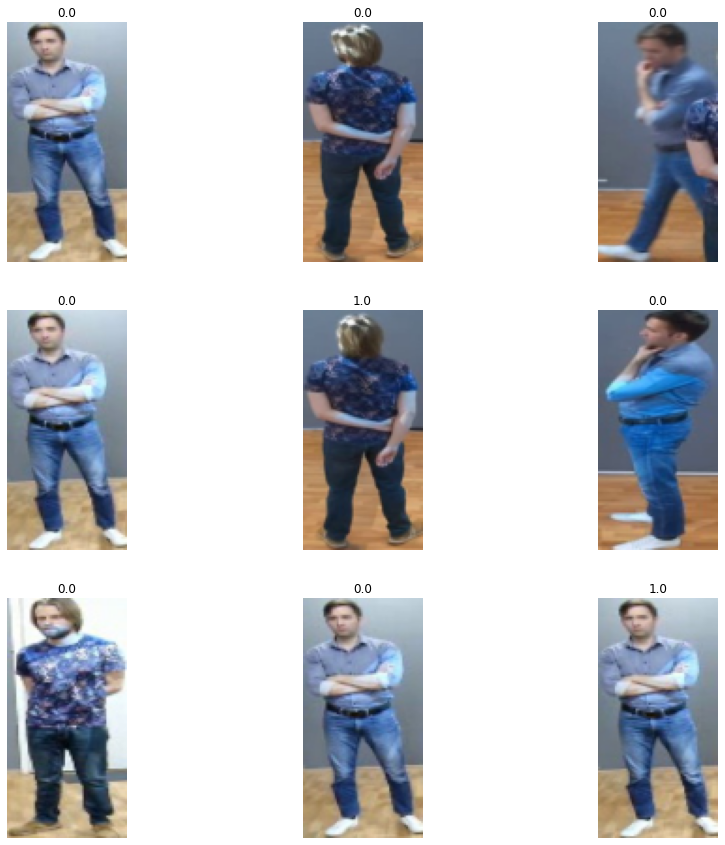

In [130]:
plt.figure(figsize=(15,15))
for i in range(9):
    ind = rand.randint(0,len(ds))
    
    plt.subplot(3, 3, 1 + i)
    img = np.array((ds[ind][0][0:3]+1.)/2, dtype=float)
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)
    plt.title(ds[ind][1])
    plt.axis('off')  
    plt.imshow(img)
plt.show()

In [131]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 6 * 14, 128)
        #self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x




class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.layer1 = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer2 = nn.Sequential(
            # State (256x16x16)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
        self.layer5 = nn.Sequential(
            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
             nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=(4,2), stride=1, padding=0))
            # Output 1
            #nn.Sigmoid())
        
    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = self.layer5(x)
        #print(x.shape)
        return self.output(x).flatten()

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)

net = Discriminator(6).cuda()

In [132]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 1e-4
b1 = 0 #0.5
b2 = 0.999
# WGAN_gradient penalty uses ADAM
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(b1, b2))

In [135]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(data[1])
        inputs = inputs.cuda()
        
        labels = labels.cuda()
        #print(labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = outputs > 0.9
        #print(outputs, labels)
        train_acc =  np.sum(outputs.cpu().detach().numpy() == labels.cpu().detach().numpy())/8*100
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f} acc: {train_acc}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.058 acc: 87.5
[1,   101] loss: 0.016 acc: 100.0
[1,   201] loss: 0.000 acc: 100.0
[1,   301] loss: 0.001 acc: 100.0
[1,   401] loss: 0.003 acc: 100.0
[1,   501] loss: 0.062 acc: 100.0
[1,   601] loss: 0.002 acc: 100.0
[1,   701] loss: 0.006 acc: 100.0
[1,   801] loss: 0.006 acc: 100.0
[2,     1] loss: 0.012 acc: 100.0
[2,   101] loss: 0.001 acc: 100.0
[2,   201] loss: 0.001 acc: 100.0
[2,   301] loss: 0.000 acc: 100.0
[2,   401] loss: 0.001 acc: 100.0
[2,   501] loss: 0.002 acc: 100.0
[2,   601] loss: 0.001 acc: 100.0
[2,   701] loss: 0.001 acc: 100.0
[2,   801] loss: 0.005 acc: 100.0
[3,     1] loss: 0.002 acc: 100.0
[3,   101] loss: 0.001 acc: 100.0
[3,   201] loss: 0.001 acc: 100.0
[3,   301] loss: 0.001 acc: 100.0
[3,   401] loss: 0.001 acc: 100.0
[3,   501] loss: 0.007 acc: 100.0
[3,   601] loss: 0.000 acc: 100.0
[3,   701] loss: 0.021 acc: 100.0
[3,   801] loss: 0.000 acc: 100.0
[4,     1] loss: 0.007 acc: 100.0
[4,   101] loss: 0.001 acc: 100.0
[4,   201] loss

In [136]:
torch.save(net.state_dict(), 'id_003')

In [89]:
128*12*12

18432